In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import tqdm.notebook as tqdm

from pathlib import Path

%matplotlib inline


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, GlobalMaxPooling2D

In [2]:
DATA_DIR_PATH = "../data/bengali_AI_handwritten_grapheme_classification"

IMG_HEIGHT = 137
IMG_WIDTH = 236

ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [3]:
original_train_df = pd.read_csv("{}/train.csv".format(DATA_DIR_PATH))
test_df = pd.read_csv("{}/test.csv".format(DATA_DIR_PATH))
class_map_df = pd.read_csv("{}/class_map.csv".format(DATA_DIR_PATH))
sample_submission_df = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR_PATH))

In [4]:
def reshape_img(img_data):
    if isinstance(img_data, pd.Series):
        img_data = img_data.to_numpy()
    
    return img_data.reshape(IMG_HEIGHT, IMG_WIDTH)

In [5]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
original_train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [7]:
CENTERED_IMAGE_PATH = "../data/bengali_centered"
PREPROCESSED_TRIAN_DATA_CSV_NAME = "new_train_data.csv"

In [8]:
def update_df_with_image_path(df: pd.DataFrame, dataset_name_list: list):
    image_path_list = list()

    for dataset_name in dataset_name_list:
        image_path_data_list = list()
        centered_image_dataset_path = os.path.join(CENTERED_IMAGE_PATH, dataset_name)

        for file in sorted(os.listdir(centered_image_dataset_path)):
            image_id, ext = os.path.splitext(file)

            if ext != ".jpg":
                continue

            idx = int(image_id.split("_")[-1])
            path_data = (idx, image_id, os.path.join(centered_image_dataset_path, file))

            image_path_data_list.append(path_data)

        image_path_data_list = sorted(image_path_data_list, key=lambda path_data: path_data[0])
        image_path_list_in_dataset = list(list(zip(*image_path_data_list))[2])
        image_path_list += image_path_list_in_dataset

    df['preprocessed_image_path'] = image_path_list

In [9]:
# update_df_with_image_path(df=original_train_df, dataset_name_list=["dataset_1", "dataset_2", "dataset_3", "dataset_4"])
# original_train_df.to_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME), mode='w', index=False)

preprocessed_train_df = pd.read_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME))

In [10]:
preprocessed_train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...
200839,Train_200839,127,2,0,ল্টি,../data/bengali_centered/dataset_4/Train_20083...


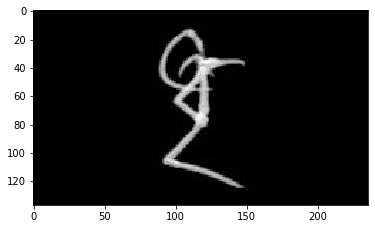

In [11]:
img = cv2.imread(preprocessed_train_df['preprocessed_image_path'][2700])
plt.imshow(img, cmap='gray')
plt.show()

In [12]:
ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [13]:
# from sklearn.model_selection import train_test_split

In [14]:
def get_len_train_test_split(full_len: int, test_ratio: float) -> tuple:
    test_len = int(full_len * test_ratio)
    train_len = full_len - test_len
    return train_len, test_len

In [15]:
def get_len_dataset(dataset) -> int:
    count = 0
    for data in dataset:
        count += 1
    
    return count

In [16]:
path_list = preprocessed_train_df['preprocessed_image_path']

root_list = preprocessed_train_df['grapheme_root']
consonant_list = preprocessed_train_df['consonant_diacritic']
vowel_list = preprocessed_train_df['vowel_diacritic']

batch_size = 256
epochs = 10

In [17]:
len_train, len_test_full = get_len_train_test_split(full_len=len(path_list), test_ratio=0.3)
len_val, len_test = get_len_train_test_split(full_len=len_test_full, test_ratio=0.7)

print(f"Train size : {len_train}, Val size : {len_val}, Test size : {len_test}")

Train size : 140588, Val size : 18076, Test size : 42176


In [18]:
# dataset = tf.data.Dataset.from_tensor_slices({
#     "path_list": path_list,
#     "root_list": root_list,
#     "consonant_list": consonant_list,
#     "vowel_list": vowel_list
# })
dataset = tf.data.Dataset.from_tensor_slices((path_list, root_list, consonant_list, vowel_list))

In [19]:
train_dataset = dataset.take(len_train)
test_dataset = dataset.skip(len_train)
val_dataset = test_dataset.take(len_val)
test_dataset = test_dataset.skip(len_val)

#print(f"Train size : {get_len_dataset(train_dataset)}, Val size : {get_len_dataset(val_dataset)}, Test size : {get_len_dataset(test_dataset)}")
# Train size : 140588, Val size : 18076, Test size : 42176

In [20]:
import efficientnet.tfkeras as efn

In [21]:
base_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [22]:
base_net.trainable = False

In [23]:
# del model

In [24]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='img')

m = base_net(inputs)
m = GlobalMaxPooling2D()(m)


# m = Conv2D(32, 3, padding='same', activation='relu')(inputs)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(64, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(128, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(256, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)


# m = Conv2D(512, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

m = Flatten()(m)
m = Dropout(rate=0.2)(m)

# m = Dense(256, activation='relu')(m)
# m = Dropout(rate=0.3)(m)
# m = Dense(128, activation='relu')(m)
# m = Dropout(rate=0.2)(m)

root = Dense(ROOT_CLASSES_NUM, activation='softmax', name='root')(m)
consonant = Dense(CONSONANT_CLASSES_NUM, activation='softmax', name='consonant')(m)
vowel = Dense(VOWEL_CLASSES_NUM, activation='softmax', name='vowel')(m)

In [25]:
model = tf.keras.Model(inputs=inputs, outputs=[root, consonant, vowel])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 137, 236, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 5, 8, 1280)   4049564     img[0][0]                        
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1280)         0           efficientnet-b0[1][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1280)         0           global_max_pooling2d[0][0]       
______________________________________________________________________________________________

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# ROOT_CLASSES_NUM = 168
# CONSONANT_CLASSES_NUM = 7
# VOWEL_CLASSES_NUM = 11

In [29]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def load_img(path_list):
    return tf.map_fn(read_img, path_list, dtype=tf.float32)

In [30]:
history_list = list()

# img_batch = None  # 이 부분 수정할 것. 비효율적임

# for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(len(path_list)):
# # for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(10240).take(1):
#     if img_batch is None:
#         time_st = time.time()
#         img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
#         time_ed = time.time()
#         print("Elapsed time for loading image data : {}".format(time_ed - time_st))

#     history = model.fit(
#         x={'img': img_batch},
#         y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
#         batch_size=128,  # 256 은 GPU 메모리 부족
#         epochs=2
#     )

#     history_list.append(history)

for epoch in range(50):
    
    print("== Epoch : {} ==\n".format(epoch))
    dataset = dataset.shuffle(len(path_list))
    
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1280):
#     for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1024).take(2):
        time_st = time.time()
        img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
        time_ed = time.time()
        print("Elapsed time for loading image data : {}".format(time_ed - time_st))
        
        history = model.fit(
            x={'img': img_batch},
            y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
            batch_size=32  # 64, 128, 256 은 GPU 메모리 부족
        )
        
        # Appending history
        history_list.append((epoch, history))
    
    print(f"Epoch {epoch} - ")

== Epoch : 0 ==

Elapsed time for loading image data : 0.9445919990539551
Train on 1280 samples
1280/1280 [==============================] - 6s 4ms/sample - loss: 141651.2043 - root_loss: 141390.0938 - consonant_loss: 43.9522 - vowel_loss: 217.1632 - root_accuracy: 0.0078 - consonant_accuracy: 0.0453 - vowel_accuracy: 0.0086
Elapsed time for loading image data : 0.9285025596618652
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140251.8404 - root_loss: 140005.5781 - consonant_loss: 36.3270 - vowel_loss: 209.9422 - root_accuracy: 0.0086 - consonant_accuracy: 0.0789 - vowel_accuracy: 0.0211
Elapsed time for loading image data : 0.9161767959594727
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 143193.7096 - root_loss: 142947.1250 - consonant_loss: 36.9899 - vowel_loss: 209.5848 - root_accuracy: 0.0055 - consonant_accuracy: 0.0742 - vowel_accuracy: 0.0156
Elapsed time for loading image data : 0.9208531379699

1280/1280 [==============================] - 2s 1ms/sample - loss: 139923.9301 - root_loss: 139716.3438 - consonant_loss: 34.0720 - vowel_loss: 173.5228 - root_accuracy: 0.0078 - consonant_accuracy: 0.1008 - vowel_accuracy: 0.0281
Elapsed time for loading image data : 0.9397509098052979
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 142540.5129 - root_loss: 142334.4062 - consonant_loss: 29.8309 - vowel_loss: 176.2752 - root_accuracy: 0.0055 - consonant_accuracy: 0.1023 - vowel_accuracy: 0.0328
Elapsed time for loading image data : 0.9514102935791016
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139947.3082 - root_loss: 139727.0000 - consonant_loss: 35.0175 - vowel_loss: 185.2938 - root_accuracy: 0.0063 - consonant_accuracy: 0.1031 - vowel_accuracy: 0.0258
Elapsed time for loading image data : 0.9673643112182617
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 147

1280/1280 [==============================] - 2s 1ms/sample - loss: 141307.3852 - root_loss: 141099.7031 - consonant_loss: 31.3702 - vowel_loss: 176.3288 - root_accuracy: 0.0102 - consonant_accuracy: 0.1172 - vowel_accuracy: 0.0453
Elapsed time for loading image data : 0.9203970432281494
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139052.3920 - root_loss: 138840.2812 - consonant_loss: 31.2576 - vowel_loss: 180.8820 - root_accuracy: 0.0094 - consonant_accuracy: 0.1187 - vowel_accuracy: 0.0453
Elapsed time for loading image data : 0.9716870784759521
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 142430.8658 - root_loss: 142222.9062 - consonant_loss: 30.3966 - vowel_loss: 177.5524 - root_accuracy: 0.0078 - consonant_accuracy: 0.1117 - vowel_accuracy: 0.0359
Elapsed time for loading image data : 0.939096212387085
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1412

1280/1280 [==============================] - 2s 1ms/sample - loss: 140662.2508 - root_loss: 140463.7656 - consonant_loss: 27.5223 - vowel_loss: 170.9660 - root_accuracy: 0.0102 - consonant_accuracy: 0.1203 - vowel_accuracy: 0.0398
Elapsed time for loading image data : 0.9421112537384033
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137108.7125 - root_loss: 136908.6094 - consonant_loss: 30.9583 - vowel_loss: 169.1313 - root_accuracy: 0.0070 - consonant_accuracy: 0.1016 - vowel_accuracy: 0.0406
Elapsed time for loading image data : 0.9806816577911377
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 142971.8875 - root_loss: 142768.6562 - consonant_loss: 28.3596 - vowel_loss: 174.8594 - root_accuracy: 0.0031 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0391
Elapsed time for loading image data : 0.9531590938568115
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 143

1280/1280 [==============================] - 2s 1ms/sample - loss: 139520.2051 - root_loss: 139319.2969 - consonant_loss: 30.1219 - vowel_loss: 170.7717 - root_accuracy: 0.0109 - consonant_accuracy: 0.1250 - vowel_accuracy: 0.0508
Elapsed time for loading image data : 0.9705777168273926
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141889.7686 - root_loss: 141692.9844 - consonant_loss: 29.9573 - vowel_loss: 166.8170 - root_accuracy: 0.0070 - consonant_accuracy: 0.1180 - vowel_accuracy: 0.0492
Elapsed time for loading image data : 0.9618401527404785
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133648.2932 - root_loss: 133457.0156 - consonant_loss: 29.4874 - vowel_loss: 161.7745 - root_accuracy: 0.0070 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0383
Elapsed time for loading image data : 0.9394605159759521
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 137101.1352 - root_loss: 136905.2656 - consonant_loss: 27.5107 - vowel_loss: 168.3292 - root_accuracy: 0.0047 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0469
Elapsed time for loading image data : 0.9705963134765625
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141263.9799 - root_loss: 141069.3281 - consonant_loss: 27.6109 - vowel_loss: 167.0175 - root_accuracy: 0.0063 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0445
Elapsed time for loading image data : 0.9721713066101074
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138033.2129 - root_loss: 137834.9062 - consonant_loss: 28.8291 - vowel_loss: 169.4792 - root_accuracy: 0.0102 - consonant_accuracy: 0.1180 - vowel_accuracy: 0.0500
Elapsed time for loading image data : 0.9611153602600098
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141

1280/1280 [==============================] - 2s 1ms/sample - loss: 141432.7346 - root_loss: 141240.0938 - consonant_loss: 27.0707 - vowel_loss: 165.5652 - root_accuracy: 0.0094 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9251627922058105
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141124.5697 - root_loss: 140939.9688 - consonant_loss: 25.8012 - vowel_loss: 158.8348 - root_accuracy: 0.0078 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0516
Elapsed time for loading image data : 0.9586181640625
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141374.6541 - root_loss: 141185.8281 - consonant_loss: 27.9882 - vowel_loss: 160.8553 - root_accuracy: 0.0078 - consonant_accuracy: 0.1266 - vowel_accuracy: 0.0617
Elapsed time for loading image data : 0.9616045951843262
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137814

1280/1280 [==============================] - 2s 1ms/sample - loss: 137206.2812 - root_loss: 137016.0156 - consonant_loss: 26.9900 - vowel_loss: 163.2761 - root_accuracy: 0.0125 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0492
Elapsed time for loading image data : 0.9369716644287109
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139130.5318 - root_loss: 138944.8750 - consonant_loss: 26.5782 - vowel_loss: 159.0465 - root_accuracy: 0.0086 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0508
Elapsed time for loading image data : 0.9710650444030762
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140490.6846 - root_loss: 140309.7500 - consonant_loss: 27.0709 - vowel_loss: 153.8452 - root_accuracy: 0.0070 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0672
Elapsed time for loading image data : 0.9540195465087891
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 141

1280/1280 [==============================] - 2s 1ms/sample - loss: 138998.1582 - root_loss: 138809.9688 - consonant_loss: 25.8083 - vowel_loss: 162.3727 - root_accuracy: 0.0109 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0672
Elapsed time for loading image data : 1.158172845840454
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139171.0953 - root_loss: 138978.6406 - consonant_loss: 26.3466 - vowel_loss: 166.1427 - root_accuracy: 0.0109 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9299378395080566
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 142318.4879 - root_loss: 142131.5312 - consonant_loss: 24.7435 - vowel_loss: 162.2239 - root_accuracy: 0.0063 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0586
Elapsed time for loading image data : 0.9531793594360352
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1372

1280/1280 [==============================] - 2s 1ms/sample - loss: 142083.0578 - root_loss: 141906.3438 - consonant_loss: 23.4510 - vowel_loss: 153.2598 - root_accuracy: 0.0086 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 0.9209749698638916
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140842.0672 - root_loss: 140660.1094 - consonant_loss: 25.0216 - vowel_loss: 156.9380 - root_accuracy: 0.0047 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9052004814147949
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140919.0416 - root_loss: 140734.6406 - consonant_loss: 25.9133 - vowel_loss: 158.5020 - root_accuracy: 0.0086 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0508
Elapsed time for loading image data : 0.9418902397155762
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134

1280/1280 [==============================] - 2s 1ms/sample - loss: 140099.3549 - root_loss: 139915.7969 - consonant_loss: 22.6943 - vowel_loss: 160.8568 - root_accuracy: 0.0148 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0586
Elapsed time for loading image data : 0.9394702911376953
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 142297.1955 - root_loss: 142108.9375 - consonant_loss: 27.7459 - vowel_loss: 160.5173 - root_accuracy: 0.0070 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9438455104827881
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136225.4930 - root_loss: 136034.9375 - consonant_loss: 24.9492 - vowel_loss: 165.5915 - root_accuracy: 0.0117 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9668734073638916
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138

1280/1280 [==============================] - 2s 1ms/sample - loss: 136419.5371 - root_loss: 136241.7031 - consonant_loss: 23.9486 - vowel_loss: 153.8844 - root_accuracy: 0.0109 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 1.0220327377319336
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136952.0594 - root_loss: 136772.6406 - consonant_loss: 25.8087 - vowel_loss: 153.6201 - root_accuracy: 0.0094 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 1.0005559921264648
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135701.2332 - root_loss: 135526.1250 - consonant_loss: 23.6044 - vowel_loss: 151.4942 - root_accuracy: 0.0070 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0500
Elapsed time for loading image data : 0.9702973365783691
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138

1280/1280 [==============================] - 2s 1ms/sample - loss: 139874.5127 - root_loss: 139697.5469 - consonant_loss: 23.3172 - vowel_loss: 153.6478 - root_accuracy: 0.0125 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0602
Elapsed time for loading image data : 0.9469344615936279
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137827.2262 - root_loss: 137647.2656 - consonant_loss: 22.9172 - vowel_loss: 157.0328 - root_accuracy: 0.0055 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9611389636993408
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138669.7846 - root_loss: 138486.4844 - consonant_loss: 23.1538 - vowel_loss: 160.1335 - root_accuracy: 0.0086 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9651424884796143
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140

1280/1280 [==============================] - 2s 1ms/sample - loss: 136472.0254 - root_loss: 136294.5938 - consonant_loss: 22.4315 - vowel_loss: 155.0036 - root_accuracy: 0.0102 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.9531524181365967
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136733.7654 - root_loss: 136560.9844 - consonant_loss: 22.6577 - vowel_loss: 150.1341 - root_accuracy: 0.0031 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.964094877243042
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138887.0205 - root_loss: 138707.0312 - consonant_loss: 22.9908 - vowel_loss: 156.9729 - root_accuracy: 0.0078 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.974449872970581
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 13757

1280/1280 [==============================] - 2s 1ms/sample - loss: 135781.3357 - root_loss: 135607.5938 - consonant_loss: 22.4068 - vowel_loss: 151.3390 - root_accuracy: 0.0102 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.970867395401001
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136100.0344 - root_loss: 135924.7656 - consonant_loss: 23.0169 - vowel_loss: 152.2438 - root_accuracy: 0.0109 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.928023099899292
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136561.4869 - root_loss: 136391.7031 - consonant_loss: 24.2717 - vowel_loss: 145.5122 - root_accuracy: 0.0109 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9793522357940674
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 14032

1280/1280 [==============================] - 2s 1ms/sample - loss: 135568.0488 - root_loss: 135393.6250 - consonant_loss: 23.0258 - vowel_loss: 151.3983 - root_accuracy: 0.0117 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9493889808654785
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137301.5947 - root_loss: 137123.0156 - consonant_loss: 20.2825 - vowel_loss: 158.3036 - root_accuracy: 0.0094 - consonant_accuracy: 0.1281 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9224498271942139
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139009.5305 - root_loss: 138832.5312 - consonant_loss: 22.0843 - vowel_loss: 154.9222 - root_accuracy: 0.0133 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9344348907470703
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 138452.1857 - root_loss: 138273.1562 - consonant_loss: 22.2313 - vowel_loss: 156.7910 - root_accuracy: 0.0133 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9322798252105713
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 139728.6877 - root_loss: 139552.6562 - consonant_loss: 23.4008 - vowel_loss: 152.6139 - root_accuracy: 0.0086 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0586
Elapsed time for loading image data : 0.9683997631072998
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136004.1342 - root_loss: 135825.7656 - consonant_loss: 23.8287 - vowel_loss: 154.5357 - root_accuracy: 0.0109 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.9621057510375977
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134

1280/1280 [==============================] - 2s 1ms/sample - loss: 133073.7793 - root_loss: 132899.6094 - consonant_loss: 21.5925 - vowel_loss: 152.5806 - root_accuracy: 0.0125 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9160466194152832
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135388.6846 - root_loss: 135215.5000 - consonant_loss: 22.4000 - vowel_loss: 150.7985 - root_accuracy: 0.0164 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9633100032806396
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137436.4252 - root_loss: 137259.7500 - consonant_loss: 21.1516 - vowel_loss: 155.5346 - root_accuracy: 0.0117 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0609
Elapsed time for loading image data : 0.9710664749145508
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135

1280/1280 [==============================] - 2s 1ms/sample - loss: 139159.8455 - root_loss: 138981.5625 - consonant_loss: 22.7589 - vowel_loss: 155.5291 - root_accuracy: 0.0188 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9783804416656494
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137492.9326 - root_loss: 137317.9531 - consonant_loss: 23.2203 - vowel_loss: 151.7717 - root_accuracy: 0.0117 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9640228748321533
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134791.2096 - root_loss: 134618.7344 - consonant_loss: 22.3574 - vowel_loss: 150.1142 - root_accuracy: 0.0109 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 1.1366617679595947
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134

1280/1280 [==============================] - 2s 1ms/sample - loss: 141293.2781 - root_loss: 141120.1094 - consonant_loss: 19.8507 - vowel_loss: 153.3135 - root_accuracy: 0.0078 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.7463638782501221
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample - loss: 131288.8285 - root_loss: 131246.0625 - consonant_loss: 21.4297 - vowel_loss: 144.1685 - root_accuracy: 0.0056 - consonant_accuracy: 0.1423 - vowel_accuracy: 0.0796
Epoch 8 - 
== Epoch : 9 ==

Elapsed time for loading image data : 0.9203939437866211
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135552.8848 - root_loss: 135379.6094 - consonant_loss: 23.4071 - vowel_loss: 149.8638 - root_accuracy: 0.0125 - consonant_accuracy: 0.1555 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9220438003540039
Train on 1280 samples
1280/1280 [==============================]

1280/1280 [==============================] - 2s 1ms/sample - loss: 135068.3195 - root_loss: 134903.2188 - consonant_loss: 21.5822 - vowel_loss: 143.5184 - root_accuracy: 0.0078 - consonant_accuracy: 0.1234 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.93416428565979
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133704.3773 - root_loss: 133531.3125 - consonant_loss: 21.1204 - vowel_loss: 151.9646 - root_accuracy: 0.0078 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.947930097579956
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134547.0471 - root_loss: 134381.4688 - consonant_loss: 22.3203 - vowel_loss: 143.2626 - root_accuracy: 0.0094 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9246459007263184
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137217

1280/1280 [==============================] - 2s 1ms/sample - loss: 135419.1930 - root_loss: 135246.5781 - consonant_loss: 21.5227 - vowel_loss: 151.1064 - root_accuracy: 0.0086 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9398007392883301
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136897.1729 - root_loss: 136726.0625 - consonant_loss: 21.7640 - vowel_loss: 149.3579 - root_accuracy: 0.0102 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 1.1407358646392822
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134248.9104 - root_loss: 134080.4688 - consonant_loss: 21.2349 - vowel_loss: 147.2069 - root_accuracy: 0.0125 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9942820072174072
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132

1280/1280 [==============================] - 2s 1ms/sample - loss: 133391.7092 - root_loss: 133220.5156 - consonant_loss: 22.1592 - vowel_loss: 149.0548 - root_accuracy: 0.0086 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9557511806488037
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131841.7471 - root_loss: 131676.6719 - consonant_loss: 22.0964 - vowel_loss: 142.9837 - root_accuracy: 0.0078 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.988727331161499
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135266.8443 - root_loss: 135101.0312 - consonant_loss: 19.1038 - vowel_loss: 146.7476 - root_accuracy: 0.0063 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9419229030609131
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1320

1280/1280 [==============================] - 2s 1ms/sample - loss: 138340.8979 - root_loss: 138172.2656 - consonant_loss: 21.5757 - vowel_loss: 147.0446 - root_accuracy: 0.0102 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0664
Elapsed time for loading image data : 0.9763360023498535
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137486.5689 - root_loss: 137317.0312 - consonant_loss: 20.9318 - vowel_loss: 148.6187 - root_accuracy: 0.0086 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 1.0010337829589844
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134935.7043 - root_loss: 134764.8438 - consonant_loss: 22.2259 - vowel_loss: 148.6226 - root_accuracy: 0.0078 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 1.0219886302947998
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 137

1280/1280 [==============================] - 2s 1ms/sample - loss: 133862.1859 - root_loss: 133691.2656 - consonant_loss: 21.0747 - vowel_loss: 149.8449 - root_accuracy: 0.0117 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9728977680206299
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 140142.2672 - root_loss: 139976.5156 - consonant_loss: 22.6942 - vowel_loss: 143.0694 - root_accuracy: 0.0172 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9312496185302734
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131537.5141 - root_loss: 131371.4375 - consonant_loss: 20.0525 - vowel_loss: 146.0329 - root_accuracy: 0.0133 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 1.1516940593719482
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 133394.1719 - root_loss: 133227.5312 - consonant_loss: 19.4710 - vowel_loss: 147.1647 - root_accuracy: 0.0156 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9975616931915283
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132273.4945 - root_loss: 132116.5469 - consonant_loss: 20.7283 - vowel_loss: 136.2020 - root_accuracy: 0.0086 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.934168815612793
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136594.4203 - root_loss: 136430.2969 - consonant_loss: 20.4677 - vowel_loss: 143.6639 - root_accuracy: 0.0086 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9367125034332275
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1363

1280/1280 [==============================] - 2s 1ms/sample - loss: 134315.2275 - root_loss: 134155.7812 - consonant_loss: 19.3105 - vowel_loss: 140.1398 - root_accuracy: 0.0102 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.0104780197143555
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133669.5963 - root_loss: 133502.2969 - consonant_loss: 20.7096 - vowel_loss: 146.5860 - root_accuracy: 0.0109 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9840989112854004
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132876.3736 - root_loss: 132708.9844 - consonant_loss: 20.8208 - vowel_loss: 146.5559 - root_accuracy: 0.0109 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 1.0274851322174072
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134

1280/1280 [==============================] - 2s 1ms/sample - loss: 132363.2529 - root_loss: 132201.4531 - consonant_loss: 19.7259 - vowel_loss: 142.0700 - root_accuracy: 0.0141 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.954704761505127
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136993.2779 - root_loss: 136829.7500 - consonant_loss: 19.5296 - vowel_loss: 143.9926 - root_accuracy: 0.0086 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9486923217773438
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134711.5041 - root_loss: 134544.0000 - consonant_loss: 20.6621 - vowel_loss: 146.8391 - root_accuracy: 0.0102 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.963050127029419
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 13541

1280/1280 [==============================] - 2s 1ms/sample - loss: 132908.5865 - root_loss: 132739.8438 - consonant_loss: 19.3713 - vowel_loss: 149.3423 - root_accuracy: 0.0117 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9987447261810303
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138460.3279 - root_loss: 138292.1719 - consonant_loss: 20.3780 - vowel_loss: 147.7708 - root_accuracy: 0.0164 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9619190692901611
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136587.8625 - root_loss: 136430.2188 - consonant_loss: 18.4885 - vowel_loss: 139.1288 - root_accuracy: 0.0086 - consonant_accuracy: 0.1578 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9768993854522705
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 136976.9736 - root_loss: 136811.0312 - consonant_loss: 18.3131 - vowel_loss: 147.6355 - root_accuracy: 0.0078 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9747443199157715
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134852.0010 - root_loss: 134689.0938 - consonant_loss: 20.2750 - vowel_loss: 142.6373 - root_accuracy: 0.0055 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9712576866149902
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135400.0918 - root_loss: 135234.8438 - consonant_loss: 18.3986 - vowel_loss: 146.8820 - root_accuracy: 0.0086 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9290626049041748
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 129133.4562 - root_loss: 128969.7734 - consonant_loss: 20.0732 - vowel_loss: 143.6063 - root_accuracy: 0.0047 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 0.9295754432678223
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133915.8941 - root_loss: 133755.8906 - consonant_loss: 19.5774 - vowel_loss: 140.4397 - root_accuracy: 0.0094 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9918539524078369
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132319.4598 - root_loss: 132161.7812 - consonant_loss: 19.4300 - vowel_loss: 138.2439 - root_accuracy: 0.0117 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9687919616699219
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132

1280/1280 [==============================] - 2s 1ms/sample - loss: 132970.6193 - root_loss: 132805.0312 - consonant_loss: 19.0733 - vowel_loss: 146.5263 - root_accuracy: 0.0102 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9801886081695557
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133775.5629 - root_loss: 133614.0781 - consonant_loss: 19.0334 - vowel_loss: 142.4574 - root_accuracy: 0.0086 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9214034080505371
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135107.7760 - root_loss: 134946.1562 - consonant_loss: 18.8672 - vowel_loss: 142.7592 - root_accuracy: 0.0148 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9244394302368164
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 131881.0707 - root_loss: 131716.4062 - consonant_loss: 20.1515 - vowel_loss: 144.4927 - root_accuracy: 0.0094 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9660263061523438
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130958.4746 - root_loss: 130797.2734 - consonant_loss: 20.1918 - vowel_loss: 141.0192 - root_accuracy: 0.0109 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9637324810028076
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131515.0287 - root_loss: 131354.2969 - consonant_loss: 18.5120 - vowel_loss: 142.2152 - root_accuracy: 0.0078 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9594495296478271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 133608.9250 - root_loss: 133452.8438 - consonant_loss: 19.4011 - vowel_loss: 136.6739 - root_accuracy: 0.0094 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9465897083282471
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133669.1994 - root_loss: 133505.7188 - consonant_loss: 19.4519 - vowel_loss: 144.0396 - root_accuracy: 0.0172 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9227573871612549
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131724.2953 - root_loss: 131562.1406 - consonant_loss: 18.7243 - vowel_loss: 143.4153 - root_accuracy: 0.0094 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9818539619445801
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 131386.2197 - root_loss: 131226.1562 - consonant_loss: 19.0143 - vowel_loss: 141.0472 - root_accuracy: 0.0055 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9720327854156494
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133999.5629 - root_loss: 133831.6562 - consonant_loss: 19.6436 - vowel_loss: 148.2564 - root_accuracy: 0.0094 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9583938121795654
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131989.5000 - root_loss: 131829.7031 - consonant_loss: 19.5551 - vowel_loss: 140.2462 - root_accuracy: 0.0125 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9492788314819336
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 130346.3619 - root_loss: 130185.5859 - consonant_loss: 18.8127 - vowel_loss: 141.9576 - root_accuracy: 0.0141 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9633345603942871
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132343.8727 - root_loss: 132186.1094 - consonant_loss: 18.3380 - vowel_loss: 139.4355 - root_accuracy: 0.0086 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9683127403259277
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134151.8584 - root_loss: 133986.8438 - consonant_loss: 18.9116 - vowel_loss: 146.0842 - root_accuracy: 0.0125 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9474771022796631
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135

1280/1280 [==============================] - 2s 1ms/sample - loss: 133543.3043 - root_loss: 133381.2188 - consonant_loss: 19.7993 - vowel_loss: 142.2745 - root_accuracy: 0.0125 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9369275569915771
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131039.7027 - root_loss: 130880.3594 - consonant_loss: 18.6125 - vowel_loss: 140.7318 - root_accuracy: 0.0102 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9400022029876709
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128960.0834 - root_loss: 128796.5391 - consonant_loss: 18.4455 - vowel_loss: 145.0851 - root_accuracy: 0.0102 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9637830257415771
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132

1280/1280 [==============================] - 2s 1ms/sample - loss: 131143.6316 - root_loss: 130978.5781 - consonant_loss: 20.5191 - vowel_loss: 144.5559 - root_accuracy: 0.0094 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9586386680603027
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136699.8510 - root_loss: 136537.3906 - consonant_loss: 18.0957 - vowel_loss: 144.3609 - root_accuracy: 0.0180 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9292402267456055
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134633.6783 - root_loss: 134467.6406 - consonant_loss: 19.6993 - vowel_loss: 146.3643 - root_accuracy: 0.0125 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 0.9467024803161621
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 134337.5002 - root_loss: 134177.0938 - consonant_loss: 18.2611 - vowel_loss: 142.1526 - root_accuracy: 0.0094 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 0.9795942306518555
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131744.1045 - root_loss: 131584.8594 - consonant_loss: 19.2828 - vowel_loss: 139.9405 - root_accuracy: 0.0109 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9613213539123535
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136463.0428 - root_loss: 136301.4062 - consonant_loss: 17.2003 - vowel_loss: 144.4495 - root_accuracy: 0.0148 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.7965579032897949
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 134521.2709 - root_loss: 134360.0156 - consonant_loss: 18.1401 - vowel_loss: 143.1272 - root_accuracy: 0.0078 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.95353102684021
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134404.5434 - root_loss: 134240.3438 - consonant_loss: 20.3462 - vowel_loss: 143.8507 - root_accuracy: 0.0141 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9838554859161377
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131356.0350 - root_loss: 131202.3125 - consonant_loss: 19.0466 - vowel_loss: 134.6698 - root_accuracy: 0.0078 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9494469165802002
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 13019

1280/1280 [==============================] - 2s 1ms/sample - loss: 125878.8201 - root_loss: 125725.2344 - consonant_loss: 19.2360 - vowel_loss: 134.3532 - root_accuracy: 0.0117 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9637131690979004
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128433.6691 - root_loss: 128270.2656 - consonant_loss: 17.7866 - vowel_loss: 145.6159 - root_accuracy: 0.0117 - consonant_accuracy: 0.1672 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9574558734893799
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131372.3309 - root_loss: 131208.1562 - consonant_loss: 19.1098 - vowel_loss: 145.0578 - root_accuracy: 0.0125 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 0.9546670913696289
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132

1280/1280 [==============================] - 2s 1ms/sample - loss: 129902.2803 - root_loss: 129740.9531 - consonant_loss: 19.3072 - vowel_loss: 142.0215 - root_accuracy: 0.0102 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9531049728393555
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133046.7441 - root_loss: 132885.6562 - consonant_loss: 18.7597 - vowel_loss: 142.3123 - root_accuracy: 0.0063 - consonant_accuracy: 0.1570 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9726779460906982
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129067.2115 - root_loss: 128904.3359 - consonant_loss: 20.0093 - vowel_loss: 142.8523 - root_accuracy: 0.0078 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9671087265014648
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128

1280/1280 [==============================] - 2s 1ms/sample - loss: 132070.2500 - root_loss: 131917.1562 - consonant_loss: 19.6413 - vowel_loss: 133.4611 - root_accuracy: 0.0125 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9254429340362549
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130057.5934 - root_loss: 129903.1641 - consonant_loss: 18.8445 - vowel_loss: 135.5887 - root_accuracy: 0.0148 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9443449974060059
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134689.7236 - root_loss: 134530.0000 - consonant_loss: 19.3052 - vowel_loss: 140.4125 - root_accuracy: 0.0117 - consonant_accuracy: 0.1695 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9312193393707275
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 132262.5105 - root_loss: 132109.5938 - consonant_loss: 19.2474 - vowel_loss: 133.6925 - root_accuracy: 0.0117 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9589602947235107
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133862.6357 - root_loss: 133705.0938 - consonant_loss: 18.7326 - vowel_loss: 138.8033 - root_accuracy: 0.0148 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9595775604248047
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130670.0672 - root_loss: 130508.3984 - consonant_loss: 19.0948 - vowel_loss: 142.5750 - root_accuracy: 0.0102 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9668252468109131
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136

1280/1280 [==============================] - 2s 1ms/sample - loss: 133872.0477 - root_loss: 133710.4844 - consonant_loss: 17.9678 - vowel_loss: 143.5819 - root_accuracy: 0.0156 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9175238609313965
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129740.0586 - root_loss: 129577.3984 - consonant_loss: 18.7911 - vowel_loss: 143.8737 - root_accuracy: 0.0141 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9344091415405273
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129983.7367 - root_loss: 129822.8906 - consonant_loss: 17.7190 - vowel_loss: 143.1472 - root_accuracy: 0.0117 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9081218242645264
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 132387.5895 - root_loss: 132231.5312 - consonant_loss: 18.9043 - vowel_loss: 137.1610 - root_accuracy: 0.0141 - consonant_accuracy: 0.1641 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9350402355194092
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126943.9875 - root_loss: 126782.9531 - consonant_loss: 18.2470 - vowel_loss: 142.7994 - root_accuracy: 0.0195 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.9522907733917236
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131690.0270 - root_loss: 131537.0469 - consonant_loss: 17.6823 - vowel_loss: 135.3002 - root_accuracy: 0.0094 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9426553249359131
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130

1280/1280 [==============================] - 2s 1ms/sample - loss: 128617.5609 - root_loss: 128450.7500 - consonant_loss: 18.7842 - vowel_loss: 148.0264 - root_accuracy: 0.0125 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9322271347045898
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130533.5725 - root_loss: 130371.2031 - consonant_loss: 20.0399 - vowel_loss: 142.3203 - root_accuracy: 0.0125 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9179177284240723
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128815.6869 - root_loss: 128658.7891 - consonant_loss: 18.1786 - vowel_loss: 138.7043 - root_accuracy: 0.0109 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9489479064941406
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133

1280/1280 [==============================] - 2s 1ms/sample - loss: 128030.5611 - root_loss: 127879.2734 - consonant_loss: 17.9388 - vowel_loss: 133.3617 - root_accuracy: 0.0109 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9752471446990967
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131505.8314 - root_loss: 131351.8281 - consonant_loss: 18.9402 - vowel_loss: 135.0600 - root_accuracy: 0.0156 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9743485450744629
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129858.5697 - root_loss: 129698.0391 - consonant_loss: 17.6942 - vowel_loss: 142.8522 - root_accuracy: 0.0164 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9370851516723633
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135

1280/1280 [==============================] - 2s 1ms/sample - loss: 131640.9533 - root_loss: 131482.2812 - consonant_loss: 17.8926 - vowel_loss: 140.7900 - root_accuracy: 0.0125 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9087553024291992
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132515.0529 - root_loss: 132352.8906 - consonant_loss: 19.2102 - vowel_loss: 142.9521 - root_accuracy: 0.0102 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9244492053985596
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133396.5178 - root_loss: 133236.3438 - consonant_loss: 17.0159 - vowel_loss: 143.1534 - root_accuracy: 0.0133 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9904532432556152
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 130859.0113 - root_loss: 130701.4375 - consonant_loss: 17.8810 - vowel_loss: 139.6747 - root_accuracy: 0.0125 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9850783348083496
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130621.9299 - root_loss: 130465.8906 - consonant_loss: 19.5572 - vowel_loss: 136.4901 - root_accuracy: 0.0117 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9706389904022217
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127042.0963 - root_loss: 126884.9844 - consonant_loss: 18.6774 - vowel_loss: 138.4236 - root_accuracy: 0.0109 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9622611999511719
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 130310.1770 - root_loss: 130159.6250 - consonant_loss: 19.2718 - vowel_loss: 131.2638 - root_accuracy: 0.0133 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9900367259979248
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133854.4113 - root_loss: 133699.5781 - consonant_loss: 19.3813 - vowel_loss: 135.4530 - root_accuracy: 0.0125 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 1.0048208236694336
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128669.8334 - root_loss: 128512.8281 - consonant_loss: 17.9145 - vowel_loss: 139.0786 - root_accuracy: 0.0141 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9666144847869873
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 131369.6279 - root_loss: 131213.8906 - consonant_loss: 17.7600 - vowel_loss: 138.0063 - root_accuracy: 0.0094 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.9531130790710449
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130311.9699 - root_loss: 130154.9609 - consonant_loss: 18.2084 - vowel_loss: 138.8064 - root_accuracy: 0.0133 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9654140472412109
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129640.8416 - root_loss: 129480.3594 - consonant_loss: 18.7323 - vowel_loss: 141.7494 - root_accuracy: 0.0094 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9898450374603271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128

1280/1280 [==============================] - 2s 1ms/sample - loss: 129137.5428 - root_loss: 128977.4766 - consonant_loss: 19.3621 - vowel_loss: 140.7210 - root_accuracy: 0.0133 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9258222579956055
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128580.4652 - root_loss: 128422.4375 - consonant_loss: 19.6115 - vowel_loss: 138.4276 - root_accuracy: 0.0117 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.948932409286499
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130892.2049 - root_loss: 130740.6250 - consonant_loss: 18.2049 - vowel_loss: 133.3711 - root_accuracy: 0.0180 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.93998122215271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130419

1280/1280 [==============================] - 2s 1ms/sample - loss: 130783.6748 - root_loss: 130623.4531 - consonant_loss: 17.6287 - vowel_loss: 142.6106 - root_accuracy: 0.0141 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9614477157592773
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129023.2279 - root_loss: 128873.1719 - consonant_loss: 16.9675 - vowel_loss: 133.0712 - root_accuracy: 0.0148 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.9407100677490234
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128031.9350 - root_loss: 127876.4766 - consonant_loss: 17.8029 - vowel_loss: 137.6529 - root_accuracy: 0.0125 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0664
Elapsed time for loading image data : 0.9424598217010498
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130

1280/1280 [==============================] - 2s 1ms/sample - loss: 128272.2449 - root_loss: 128114.1406 - consonant_loss: 18.6661 - vowel_loss: 139.4558 - root_accuracy: 0.0148 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.890812873840332
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128363.3926 - root_loss: 128206.1719 - consonant_loss: 17.8424 - vowel_loss: 139.3619 - root_accuracy: 0.0117 - consonant_accuracy: 0.1625 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9309988021850586
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127636.5963 - root_loss: 127482.4141 - consonant_loss: 17.7202 - vowel_loss: 136.4716 - root_accuracy: 0.0070 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.939866304397583
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 12939

1280/1280 [==============================] - 2s 1ms/sample - loss: 129220.6230 - root_loss: 129064.1641 - consonant_loss: 19.6816 - vowel_loss: 136.7698 - root_accuracy: 0.0102 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9444479942321777
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128659.8895 - root_loss: 128504.7969 - consonant_loss: 18.2370 - vowel_loss: 136.8545 - root_accuracy: 0.0172 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9623873233795166
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130855.9111 - root_loss: 130698.1641 - consonant_loss: 18.8907 - vowel_loss: 138.8626 - root_accuracy: 0.0188 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9733123779296875
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 128682.0732 - root_loss: 128530.0469 - consonant_loss: 18.8956 - vowel_loss: 133.1230 - root_accuracy: 0.0133 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9747908115386963
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130425.4834 - root_loss: 130272.7266 - consonant_loss: 17.0296 - vowel_loss: 135.7221 - root_accuracy: 0.0172 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 0.9409217834472656
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127896.7742 - root_loss: 127735.9609 - consonant_loss: 19.4981 - vowel_loss: 141.2953 - root_accuracy: 0.0109 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9327256679534912
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134

1280/1280 [==============================] - 2s 1ms/sample - loss: 129455.6299 - root_loss: 129301.1719 - consonant_loss: 18.2095 - vowel_loss: 136.2538 - root_accuracy: 0.0156 - consonant_accuracy: 0.1648 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9868481159210205
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128084.4504 - root_loss: 127926.3906 - consonant_loss: 18.3046 - vowel_loss: 139.7584 - root_accuracy: 0.0055 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0656
Elapsed time for loading image data : 0.9731454849243164
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129926.0822 - root_loss: 129771.1250 - consonant_loss: 17.3859 - vowel_loss: 137.5893 - root_accuracy: 0.0063 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9479658603668213
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 128952.4033 - root_loss: 128799.8516 - consonant_loss: 16.4635 - vowel_loss: 136.1131 - root_accuracy: 0.0180 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9831311702728271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126170.1889 - root_loss: 126017.0859 - consonant_loss: 19.0785 - vowel_loss: 134.0190 - root_accuracy: 0.0133 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9228270053863525
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131516.6096 - root_loss: 131360.4062 - consonant_loss: 17.3513 - vowel_loss: 138.8606 - root_accuracy: 0.0078 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9036977291107178
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132

1280/1280 [==============================] - 2s 1ms/sample - loss: 128935.0629 - root_loss: 128778.7500 - consonant_loss: 18.9957 - vowel_loss: 137.3064 - root_accuracy: 0.0188 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 0.9545235633850098
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130654.8324 - root_loss: 130499.0781 - consonant_loss: 18.6466 - vowel_loss: 137.1141 - root_accuracy: 0.0141 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9767756462097168
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123395.3828 - root_loss: 123245.2891 - consonant_loss: 18.3989 - vowel_loss: 131.6696 - root_accuracy: 0.0164 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9738545417785645
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 126001.5877 - root_loss: 125848.0000 - consonant_loss: 17.5989 - vowel_loss: 135.9866 - root_accuracy: 0.0125 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9298834800720215
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130010.7812 - root_loss: 129855.0234 - consonant_loss: 17.9295 - vowel_loss: 137.8389 - root_accuracy: 0.0195 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9645178318023682
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127997.1262 - root_loss: 127838.5859 - consonant_loss: 18.5566 - vowel_loss: 139.9841 - root_accuracy: 0.0086 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9695186614990234
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130

1280/1280 [==============================] - 2s 1ms/sample - loss: 130330.0027 - root_loss: 130176.4375 - consonant_loss: 17.9877 - vowel_loss: 135.5974 - root_accuracy: 0.0133 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9559605121612549
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130930.5221 - root_loss: 130781.0781 - consonant_loss: 17.4858 - vowel_loss: 131.9578 - root_accuracy: 0.0125 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0953
Elapsed time for loading image data : 0.943159818649292
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129830.0664 - root_loss: 129679.5469 - consonant_loss: 18.7904 - vowel_loss: 131.7420 - root_accuracy: 0.0141 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 0.9479844570159912
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1278

1280/1280 [==============================] - 2s 1ms/sample - loss: 127081.9992 - root_loss: 126924.5781 - consonant_loss: 18.5089 - vowel_loss: 138.9414 - root_accuracy: 0.0141 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9654064178466797
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128533.9650 - root_loss: 128383.5391 - consonant_loss: 18.0680 - vowel_loss: 132.3642 - root_accuracy: 0.0094 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9728007316589355
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129448.4467 - root_loss: 129298.7344 - consonant_loss: 18.5147 - vowel_loss: 131.2026 - root_accuracy: 0.0109 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9708576202392578
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 128981.8924 - root_loss: 128825.3594 - consonant_loss: 18.3321 - vowel_loss: 138.1839 - root_accuracy: 0.0133 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9567165374755859
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129292.0881 - root_loss: 129132.3906 - consonant_loss: 18.4445 - vowel_loss: 141.2600 - root_accuracy: 0.0141 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9841151237487793
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131427.2648 - root_loss: 131270.6406 - consonant_loss: 17.3073 - vowel_loss: 139.3258 - root_accuracy: 0.0148 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9762911796569824
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 131617.7162 - root_loss: 131471.0312 - consonant_loss: 16.6109 - vowel_loss: 130.0835 - root_accuracy: 0.0141 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.9450914859771729
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131774.0910 - root_loss: 131623.1562 - consonant_loss: 17.6827 - vowel_loss: 133.2388 - root_accuracy: 0.0148 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9419288635253906
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129958.9080 - root_loss: 129807.9219 - consonant_loss: 18.1770 - vowel_loss: 132.8089 - root_accuracy: 0.0109 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9762687683105469
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124

1280/1280 [==============================] - 2s 1ms/sample - loss: 130203.8166 - root_loss: 130050.2969 - consonant_loss: 16.5220 - vowel_loss: 136.9941 - root_accuracy: 0.0094 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9369328022003174
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130778.8676 - root_loss: 130622.1094 - consonant_loss: 19.9685 - vowel_loss: 136.7689 - root_accuracy: 0.0148 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.972527265548706
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126040.6445 - root_loss: 125878.9531 - consonant_loss: 18.1203 - vowel_loss: 143.5664 - root_accuracy: 0.0125 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9493699073791504
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1285

1280/1280 [==============================] - 2s 1ms/sample - loss: 127192.1660 - root_loss: 127044.0234 - consonant_loss: 17.7294 - vowel_loss: 130.4126 - root_accuracy: 0.0148 - consonant_accuracy: 0.1672 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9345479011535645
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127904.4174 - root_loss: 127751.5000 - consonant_loss: 18.9971 - vowel_loss: 133.9126 - root_accuracy: 0.0172 - consonant_accuracy: 0.1203 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.922795295715332
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125684.8855 - root_loss: 125536.4375 - consonant_loss: 17.4220 - vowel_loss: 131.0459 - root_accuracy: 0.0172 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9489169120788574
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1290

1280/1280 [==============================] - 2s 1ms/sample - loss: 130675.5408 - root_loss: 130523.0391 - consonant_loss: 17.1998 - vowel_loss: 135.2776 - root_accuracy: 0.0117 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9545412063598633
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128559.3037 - root_loss: 128406.8281 - consonant_loss: 17.2965 - vowel_loss: 135.1819 - root_accuracy: 0.0148 - consonant_accuracy: 0.1234 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9766137599945068
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129436.0830 - root_loss: 129279.0781 - consonant_loss: 17.3180 - vowel_loss: 139.6966 - root_accuracy: 0.0148 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 1.1137175559997559
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 126897.7000 - root_loss: 126745.0000 - consonant_loss: 17.0695 - vowel_loss: 135.6342 - root_accuracy: 0.0117 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0664
Elapsed time for loading image data : 0.9289083480834961
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128657.9113 - root_loss: 128507.2031 - consonant_loss: 17.2734 - vowel_loss: 133.4453 - root_accuracy: 0.0141 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9516901969909668
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128394.0691 - root_loss: 128239.7031 - consonant_loss: 17.3681 - vowel_loss: 137.0020 - root_accuracy: 0.0180 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.9585955142974854
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 126919.7926 - root_loss: 126767.0781 - consonant_loss: 17.2772 - vowel_loss: 135.4304 - root_accuracy: 0.0094 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9811618328094482
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127559.4885 - root_loss: 127406.9141 - consonant_loss: 17.6168 - vowel_loss: 134.9767 - root_accuracy: 0.0148 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9751019477844238
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126882.1664 - root_loss: 126736.2266 - consonant_loss: 18.7106 - vowel_loss: 127.2022 - root_accuracy: 0.0148 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9202532768249512
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131

1280/1280 [==============================] - 2s 1ms/sample - loss: 127865.4951 - root_loss: 127713.4531 - consonant_loss: 18.0950 - vowel_loss: 133.9529 - root_accuracy: 0.0172 - consonant_accuracy: 0.1586 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9473788738250732
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127452.6463 - root_loss: 127296.3516 - consonant_loss: 15.7924 - vowel_loss: 140.5066 - root_accuracy: 0.0109 - consonant_accuracy: 0.1555 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.945523738861084
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128837.4402 - root_loss: 128684.9531 - consonant_loss: 17.2996 - vowel_loss: 135.1915 - root_accuracy: 0.0141 - consonant_accuracy: 0.1586 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9619510173797607
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1275

1280/1280 [==============================] - 2s 1ms/sample - loss: 129526.4236 - root_loss: 129370.4219 - consonant_loss: 17.5282 - vowel_loss: 138.4635 - root_accuracy: 0.0141 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9306399822235107
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130596.7178 - root_loss: 130441.8594 - consonant_loss: 18.5372 - vowel_loss: 136.3329 - root_accuracy: 0.0141 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9467227458953857
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126619.1020 - root_loss: 126462.6484 - consonant_loss: 18.8995 - vowel_loss: 137.5570 - root_accuracy: 0.0094 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9683310985565186
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125

1280/1280 [==============================] - 2s 1ms/sample - loss: 123998.6453 - root_loss: 123845.0391 - consonant_loss: 17.1247 - vowel_loss: 136.4667 - root_accuracy: 0.0133 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.959653377532959
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127106.1275 - root_loss: 126952.6719 - consonant_loss: 17.9136 - vowel_loss: 135.5440 - root_accuracy: 0.0109 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9221336841583252
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129133.0713 - root_loss: 128977.5391 - consonant_loss: 17.1543 - vowel_loss: 138.3770 - root_accuracy: 0.0148 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9165654182434082
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1266

1280/1280 [==============================] - 2s 1ms/sample - loss: 129734.6057 - root_loss: 129578.5469 - consonant_loss: 18.2889 - vowel_loss: 137.7914 - root_accuracy: 0.0180 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9295506477355957
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129080.8035 - root_loss: 128923.8125 - consonant_loss: 18.7412 - vowel_loss: 138.2478 - root_accuracy: 0.0125 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9316513538360596
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126389.6166 - root_loss: 126233.8359 - consonant_loss: 18.2372 - vowel_loss: 137.5417 - root_accuracy: 0.0141 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9894216060638428
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 132399.3926 - root_loss: 132246.1094 - consonant_loss: 16.0794 - vowel_loss: 137.1858 - root_accuracy: 0.0125 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.8396921157836914
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample - loss: 123648.5291 - root_loss: 123531.1016 - consonant_loss: 17.4176 - vowel_loss: 127.8441 - root_accuracy: 0.0187 - consonant_accuracy: 0.1451 - vowel_accuracy: 0.0908
Epoch 34 - 
== Epoch : 35 ==

Elapsed time for loading image data : 0.9530544281005859
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127074.0615 - root_loss: 126920.1641 - consonant_loss: 19.3114 - vowel_loss: 134.5961 - root_accuracy: 0.0102 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9378848075866699
Train on 1280 samples
1280/1280 [=============================

1280/1280 [==============================] - 2s 1ms/sample - loss: 127054.0072 - root_loss: 126907.8125 - consonant_loss: 17.8333 - vowel_loss: 128.3632 - root_accuracy: 0.0102 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9770181179046631
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126017.2824 - root_loss: 125861.8750 - consonant_loss: 17.6275 - vowel_loss: 137.7951 - root_accuracy: 0.0148 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.967703104019165
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126345.8418 - root_loss: 126198.2031 - consonant_loss: 18.5339 - vowel_loss: 129.0981 - root_accuracy: 0.0117 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9466507434844971
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1291

1280/1280 [==============================] - 2s 1ms/sample - loss: 127748.5721 - root_loss: 127590.8281 - consonant_loss: 17.9651 - vowel_loss: 139.7601 - root_accuracy: 0.0117 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0617
Elapsed time for loading image data : 0.9587264060974121
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127457.3207 - root_loss: 127305.0000 - consonant_loss: 18.1950 - vowel_loss: 134.1162 - root_accuracy: 0.0117 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9274570941925049
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127324.1506 - root_loss: 127171.5625 - consonant_loss: 17.8825 - vowel_loss: 134.7065 - root_accuracy: 0.0117 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0672
Elapsed time for loading image data : 0.9642367362976074
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125

1280/1280 [==============================] - 2s 1ms/sample - loss: 125057.8326 - root_loss: 124902.4766 - consonant_loss: 18.9165 - vowel_loss: 136.4357 - root_accuracy: 0.0086 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9641778469085693
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124490.5799 - root_loss: 124342.0469 - consonant_loss: 18.6195 - vowel_loss: 129.9041 - root_accuracy: 0.0156 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.99397873878479
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127983.9332 - root_loss: 127833.6484 - consonant_loss: 16.1951 - vowel_loss: 134.1051 - root_accuracy: 0.0180 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9721457958221436
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 12432

1280/1280 [==============================] - 2s 1ms/sample - loss: 130351.7523 - root_loss: 130197.7891 - consonant_loss: 18.2866 - vowel_loss: 135.6661 - root_accuracy: 0.0180 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9820971488952637
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129696.2508 - root_loss: 129539.0156 - consonant_loss: 17.6932 - vowel_loss: 139.5452 - root_accuracy: 0.0109 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9419300556182861
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126350.7982 - root_loss: 126196.8359 - consonant_loss: 18.6950 - vowel_loss: 135.2693 - root_accuracy: 0.0211 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9531335830688477
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128

1280/1280 [==============================] - 2s 1ms/sample - loss: 127022.4500 - root_loss: 126867.5000 - consonant_loss: 18.1561 - vowel_loss: 136.7759 - root_accuracy: 0.0172 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9397385120391846
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131272.9652 - root_loss: 131122.5938 - consonant_loss: 19.4404 - vowel_loss: 130.9410 - root_accuracy: 0.0148 - consonant_accuracy: 0.1281 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 0.9664831161499023
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123556.3436 - root_loss: 123404.9141 - consonant_loss: 17.3145 - vowel_loss: 134.1170 - root_accuracy: 0.0117 - consonant_accuracy: 0.1648 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9827713966369629
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 125745.1371 - root_loss: 125591.2344 - consonant_loss: 16.8640 - vowel_loss: 137.0324 - root_accuracy: 0.0172 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9454686641693115
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125449.3520 - root_loss: 125303.1406 - consonant_loss: 17.9371 - vowel_loss: 128.3054 - root_accuracy: 0.0125 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9708082675933838
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128594.8266 - root_loss: 128443.5234 - consonant_loss: 17.7181 - vowel_loss: 133.5946 - root_accuracy: 0.0133 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9273507595062256
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128

1280/1280 [==============================] - 2s 1ms/sample - loss: 126915.0875 - root_loss: 126768.5781 - consonant_loss: 16.8816 - vowel_loss: 129.6444 - root_accuracy: 0.0148 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9274446964263916
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125773.1115 - root_loss: 125619.0391 - consonant_loss: 18.0566 - vowel_loss: 136.0100 - root_accuracy: 0.0172 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.946099042892456
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124793.5563 - root_loss: 124641.9766 - consonant_loss: 18.2514 - vowel_loss: 133.3291 - root_accuracy: 0.0133 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9053115844726562
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1265

1280/1280 [==============================] - 2s 1ms/sample - loss: 124648.0883 - root_loss: 124497.8125 - consonant_loss: 17.4005 - vowel_loss: 132.8753 - root_accuracy: 0.0125 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9638843536376953
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129264.7500 - root_loss: 129111.2734 - consonant_loss: 17.1369 - vowel_loss: 136.3333 - root_accuracy: 0.0109 - consonant_accuracy: 0.1625 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9921936988830566
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127723.4139 - root_loss: 127569.2656 - consonant_loss: 18.0590 - vowel_loss: 136.0815 - root_accuracy: 0.0148 - consonant_accuracy: 0.1586 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9548742771148682
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 125850.8119 - root_loss: 125695.1250 - consonant_loss: 16.9747 - vowel_loss: 138.7196 - root_accuracy: 0.0148 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9717090129852295
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130961.5336 - root_loss: 130805.3516 - consonant_loss: 17.9223 - vowel_loss: 138.2910 - root_accuracy: 0.0156 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9928278923034668
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129508.9350 - root_loss: 129363.6094 - consonant_loss: 16.3291 - vowel_loss: 129.0060 - root_accuracy: 0.0086 - consonant_accuracy: 0.1641 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9824314117431641
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 129349.9381 - root_loss: 129197.8359 - consonant_loss: 16.2784 - vowel_loss: 135.8206 - root_accuracy: 0.0148 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9546246528625488
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127754.0912 - root_loss: 127603.6875 - consonant_loss: 18.0103 - vowel_loss: 132.4166 - root_accuracy: 0.0117 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9938926696777344
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128031.5664 - root_loss: 127878.8984 - consonant_loss: 16.3086 - vowel_loss: 136.3512 - root_accuracy: 0.0133 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9369807243347168
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 122874.4037 - root_loss: 122722.9609 - consonant_loss: 18.0249 - vowel_loss: 133.4178 - root_accuracy: 0.0109 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9457049369812012
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127255.0133 - root_loss: 127103.3125 - consonant_loss: 17.5438 - vowel_loss: 134.1594 - root_accuracy: 0.0133 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9649560451507568
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124508.6816 - root_loss: 124363.1484 - consonant_loss: 17.5555 - vowel_loss: 127.9834 - root_accuracy: 0.0125 - consonant_accuracy: 0.1570 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.950000524520874
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1262

1280/1280 [==============================] - 2s 1ms/sample - loss: 125647.4982 - root_loss: 125494.4141 - consonant_loss: 17.3003 - vowel_loss: 135.8059 - root_accuracy: 0.0125 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.8977115154266357
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127404.0221 - root_loss: 127253.8984 - consonant_loss: 17.0935 - vowel_loss: 133.0349 - root_accuracy: 0.0133 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9431467056274414
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128583.4650 - root_loss: 128431.9844 - consonant_loss: 17.0135 - vowel_loss: 134.4794 - root_accuracy: 0.0148 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9790909290313721
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 125730.1002 - root_loss: 125578.8281 - consonant_loss: 18.0812 - vowel_loss: 133.2073 - root_accuracy: 0.0148 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0609
Elapsed time for loading image data : 0.9689326286315918
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124786.1340 - root_loss: 124637.1406 - consonant_loss: 18.1989 - vowel_loss: 130.8103 - root_accuracy: 0.0117 - consonant_accuracy: 0.1586 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9721879959106445
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124358.0930 - root_loss: 124205.4531 - consonant_loss: 16.8405 - vowel_loss: 135.7789 - root_accuracy: 0.0094 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9233381748199463
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 126769.2357 - root_loss: 126624.2500 - consonant_loss: 17.5969 - vowel_loss: 127.3926 - root_accuracy: 0.0148 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9477429389953613
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127379.6072 - root_loss: 127229.1719 - consonant_loss: 17.7067 - vowel_loss: 132.7219 - root_accuracy: 0.0188 - consonant_accuracy: 0.1617 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9277729988098145
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125344.8098 - root_loss: 125193.7969 - consonant_loss: 17.0869 - vowel_loss: 133.9065 - root_accuracy: 0.0164 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9744882583618164
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125

1280/1280 [==============================] - 2s 1ms/sample - loss: 125303.3656 - root_loss: 125153.4375 - consonant_loss: 17.2746 - vowel_loss: 132.6713 - root_accuracy: 0.0125 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9308640956878662
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127130.5287 - root_loss: 126974.0000 - consonant_loss: 17.9554 - vowel_loss: 138.5790 - root_accuracy: 0.0109 - consonant_accuracy: 0.1711 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.981062650680542
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125023.2268 - root_loss: 124874.8906 - consonant_loss: 17.9288 - vowel_loss: 130.3917 - root_accuracy: 0.0148 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9166603088378906
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1257

1280/1280 [==============================] - 2s 1ms/sample - loss: 124594.8211 - root_loss: 124446.0234 - consonant_loss: 17.2432 - vowel_loss: 131.5491 - root_accuracy: 0.0141 - consonant_accuracy: 0.1641 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9330019950866699
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126114.4170 - root_loss: 125967.5625 - consonant_loss: 16.8671 - vowel_loss: 129.9832 - root_accuracy: 0.0141 - consonant_accuracy: 0.1555 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9718880653381348
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128094.4053 - root_loss: 127939.1016 - consonant_loss: 17.3603 - vowel_loss: 137.9402 - root_accuracy: 0.0242 - consonant_accuracy: 0.1555 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9653811454772949
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128

1280/1280 [==============================] - 2s 1ms/sample - loss: 128354.2791 - root_loss: 128201.9531 - consonant_loss: 18.3725 - vowel_loss: 133.9512 - root_accuracy: 0.0125 - consonant_accuracy: 0.1688 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9281024932861328
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125314.8078 - root_loss: 125163.6875 - consonant_loss: 17.0688 - vowel_loss: 134.0345 - root_accuracy: 0.0156 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9235994815826416
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 122658.3154 - root_loss: 122507.0156 - consonant_loss: 16.9268 - vowel_loss: 134.3627 - root_accuracy: 0.0180 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9830043315887451
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125

1280/1280 [==============================] - 2s 1ms/sample - loss: 124158.2107 - root_loss: 124003.0156 - consonant_loss: 18.9249 - vowel_loss: 136.2938 - root_accuracy: 0.0141 - consonant_accuracy: 0.1570 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9872713088989258
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130301.7582 - root_loss: 130148.2344 - consonant_loss: 16.7433 - vowel_loss: 136.7963 - root_accuracy: 0.0148 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9863362312316895
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128004.4961 - root_loss: 127847.5156 - consonant_loss: 18.1190 - vowel_loss: 138.8512 - root_accuracy: 0.0109 - consonant_accuracy: 0.1680 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 1.0026850700378418
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 127110.4920 - root_loss: 126958.8984 - consonant_loss: 16.9374 - vowel_loss: 134.6703 - root_accuracy: 0.0164 - consonant_accuracy: 0.1602 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9462153911590576
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125639.0941 - root_loss: 125490.2109 - consonant_loss: 17.8526 - vowel_loss: 131.0294 - root_accuracy: 0.0203 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9353225231170654
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130145.4158 - root_loss: 129993.2891 - consonant_loss: 15.9384 - vowel_loss: 136.1967 - root_accuracy: 0.0148 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.7746615409851074
Train on 1068 samples
1068/1068 [==============================] - 2s 1ms/sample - loss: 122

1280/1280 [==============================] - 2s 1ms/sample - loss: 127351.7104 - root_loss: 127200.0391 - consonant_loss: 16.9115 - vowel_loss: 134.7530 - root_accuracy: 0.0148 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0664
Elapsed time for loading image data : 0.9377491474151611
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128870.2383 - root_loss: 128718.2500 - consonant_loss: 18.9892 - vowel_loss: 132.9823 - root_accuracy: 0.0141 - consonant_accuracy: 0.1641 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9914319515228271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126381.8422 - root_loss: 126235.4141 - consonant_loss: 17.6870 - vowel_loss: 128.7258 - root_accuracy: 0.0148 - consonant_accuracy: 0.1672 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9344942569732666
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124

1280/1280 [==============================] - 2s 1ms/sample - loss: 120452.8289 - root_loss: 120305.7969 - consonant_loss: 17.9577 - vowel_loss: 129.0910 - root_accuracy: 0.0156 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9574000835418701
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 122355.4514 - root_loss: 122199.1250 - consonant_loss: 16.5846 - vowel_loss: 139.7317 - root_accuracy: 0.0141 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9451932907104492
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125338.9520 - root_loss: 125185.2734 - consonant_loss: 17.8430 - vowel_loss: 135.8593 - root_accuracy: 0.0133 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 0.9165916442871094
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 123492.0076 - root_loss: 123338.4219 - consonant_loss: 18.1345 - vowel_loss: 135.4467 - root_accuracy: 0.0148 - consonant_accuracy: 0.1695 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9132955074310303
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126863.4361 - root_loss: 126711.5156 - consonant_loss: 17.5455 - vowel_loss: 134.4105 - root_accuracy: 0.0094 - consonant_accuracy: 0.1688 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9379153251647949
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123308.5369 - root_loss: 123155.8984 - consonant_loss: 18.7627 - vowel_loss: 133.8568 - root_accuracy: 0.0141 - consonant_accuracy: 0.1617 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9683327674865723
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 122

1280/1280 [==============================] - 2s 1ms/sample - loss: 125503.2779 - root_loss: 125355.4141 - consonant_loss: 18.3908 - vowel_loss: 129.4933 - root_accuracy: 0.0211 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9342925548553467
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124080.5902 - root_loss: 123935.2109 - consonant_loss: 17.7728 - vowel_loss: 127.5932 - root_accuracy: 0.0141 - consonant_accuracy: 0.1688 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9289484024047852
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128230.0346 - root_loss: 128078.3750 - consonant_loss: 18.1570 - vowel_loss: 133.4913 - root_accuracy: 0.0148 - consonant_accuracy: 0.1711 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.933448314666748
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1278

1280/1280 [==============================] - 2s 1ms/sample - loss: 126124.6057 - root_loss: 125980.6406 - consonant_loss: 18.1535 - vowel_loss: 125.8081 - root_accuracy: 0.0109 - consonant_accuracy: 0.1734 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9812061786651611
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127438.5451 - root_loss: 127287.3594 - consonant_loss: 17.6905 - vowel_loss: 133.4873 - root_accuracy: 0.0141 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9868378639221191
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125471.6949 - root_loss: 125314.5000 - consonant_loss: 18.0216 - vowel_loss: 139.1891 - root_accuracy: 0.0109 - consonant_accuracy: 0.1664 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9182538986206055
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 127834.3857 - root_loss: 127683.1719 - consonant_loss: 16.9470 - vowel_loss: 134.2708 - root_accuracy: 0.0234 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0609
Elapsed time for loading image data : 1.0297596454620361
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124537.3484 - root_loss: 124380.3750 - consonant_loss: 17.8201 - vowel_loss: 139.1494 - root_accuracy: 0.0188 - consonant_accuracy: 0.1742 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9713931083679199
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124262.7234 - root_loss: 124110.0234 - consonant_loss: 16.7632 - vowel_loss: 135.9729 - root_accuracy: 0.0195 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9940180778503418
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123

1280/1280 [==============================] - 2s 1ms/sample - loss: 126734.9447 - root_loss: 126586.6875 - consonant_loss: 17.8447 - vowel_loss: 130.4104 - root_accuracy: 0.0094 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.993682861328125
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 120860.0641 - root_loss: 120708.9609 - consonant_loss: 17.2896 - vowel_loss: 133.8033 - root_accuracy: 0.0109 - consonant_accuracy: 0.1680 - vowel_accuracy: 0.0688
Elapsed time for loading image data : 0.9356706142425537
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124837.2430 - root_loss: 124690.5234 - consonant_loss: 16.7423 - vowel_loss: 129.9679 - root_accuracy: 0.0141 - consonant_accuracy: 0.1617 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9871089458465576
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 1247

1280/1280 [==============================] - 2s 1ms/sample - loss: 123073.6539 - root_loss: 122912.8750 - consonant_loss: 17.8013 - vowel_loss: 142.9733 - root_accuracy: 0.0133 - consonant_accuracy: 0.1633 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.9611525535583496
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125165.6553 - root_loss: 125009.1641 - consonant_loss: 18.9850 - vowel_loss: 137.5050 - root_accuracy: 0.0195 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9388401508331299
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123795.6014 - root_loss: 123644.9141 - consonant_loss: 17.3132 - vowel_loss: 133.3806 - root_accuracy: 0.0117 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9401636123657227
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127

1280/1280 [==============================] - 2s 1ms/sample - loss: 122702.7744 - root_loss: 122555.5234 - consonant_loss: 17.0943 - vowel_loss: 130.1541 - root_accuracy: 0.0172 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0602
Elapsed time for loading image data : 0.9942455291748047
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125564.6590 - root_loss: 125418.2969 - consonant_loss: 17.9988 - vowel_loss: 128.3632 - root_accuracy: 0.0117 - consonant_accuracy: 0.1648 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9698212146759033
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124186.8436 - root_loss: 124029.6094 - consonant_loss: 16.8570 - vowel_loss: 140.3672 - root_accuracy: 0.0172 - consonant_accuracy: 0.1773 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9896178245544434
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129

1280/1280 [==============================] - 2s 1ms/sample - loss: 126499.9111 - root_loss: 126346.6250 - consonant_loss: 17.0287 - vowel_loss: 136.2611 - root_accuracy: 0.0203 - consonant_accuracy: 0.1578 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9450101852416992
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126689.8604 - root_loss: 126535.1094 - consonant_loss: 18.3259 - vowel_loss: 136.4406 - root_accuracy: 0.0117 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0672
Elapsed time for loading image data : 0.9471807479858398
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127506.9258 - root_loss: 127354.5234 - consonant_loss: 16.1799 - vowel_loss: 136.2383 - root_accuracy: 0.0141 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9656820297241211
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

1280/1280 [==============================] - 2s 1ms/sample - loss: 124853.3582 - root_loss: 124700.6406 - consonant_loss: 17.0971 - vowel_loss: 135.6170 - root_accuracy: 0.0156 - consonant_accuracy: 0.1813 - vowel_accuracy: 0.0727
Elapsed time for loading image data : 0.9836981296539307
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124024.1854 - root_loss: 123874.0469 - consonant_loss: 18.6727 - vowel_loss: 131.4851 - root_accuracy: 0.0148 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9799878597259521
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 120993.3689 - root_loss: 120840.1641 - consonant_loss: 17.9178 - vowel_loss: 135.2859 - root_accuracy: 0.0109 - consonant_accuracy: 0.1641 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9089455604553223
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125

1280/1280 [==============================] - 2s 1ms/sample - loss: 124591.4738 - root_loss: 124445.6406 - consonant_loss: 18.4410 - vowel_loss: 127.3996 - root_accuracy: 0.0102 - consonant_accuracy: 0.1656 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9636232852935791
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127664.8631 - root_loss: 127514.4609 - consonant_loss: 18.5597 - vowel_loss: 131.8357 - root_accuracy: 0.0117 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9272308349609375
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123934.5564 - root_loss: 123780.5000 - consonant_loss: 17.2359 - vowel_loss: 136.8301 - root_accuracy: 0.0172 - consonant_accuracy: 0.1656 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9292178153991699
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126

In [32]:
model

In [33]:
model.save("./models/efficientNetB3_epoch_50.h5")

In [31]:
history.epoch

[0]

In [ ]:
history

In [ ]:
model.

In [ ]:
a

In [ ]:
a = [1]

In [265]:
for epoch in range(epochs):
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(batch_size).take(1):
        print(path, root, consonant, vowel)
    
    print(f"Epoch {epoch} - ")

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

In [126]:
# x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
#     train_test_split(path_list, root_one_hot_list, consonant_one_hot_list, vowel_one_hot_list, test_size=0.3)

In [127]:
x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
    train_test_split(path_list, root_list, consonant_list, vowel_list, test_size=0.3)

In [128]:
x_train_path

87499     ../data/bengali_centered/dataset_2/Train_87499...
75515     ../data/bengali_centered/dataset_2/Train_75515...
95056     ../data/bengali_centered/dataset_2/Train_95056...
100572    ../data/bengali_centered/dataset_3/Train_10057...
144608    ../data/bengali_centered/dataset_3/Train_14460...
                                ...                        
49302     ../data/bengali_centered/dataset_1/Train_49302...
37481     ../data/bengali_centered/dataset_1/Train_37481...
141396    ../data/bengali_centered/dataset_3/Train_14139...
43364     ../data/bengali_centered/dataset_1/Train_43364...
182671    ../data/bengali_centered/dataset_4/Train_18267...
Name: preprocessed_image_path, Length: 140588, dtype: object

In [ ]:
tf.data.Dataset.from_tensor_slices

In [22]:
size = 5000

In [23]:
tmp_x_trains = list()
img = None

time_st = time.time()
for i in range(size):
    img = tf.io.read_file(x_train_path[i])
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    tmp_x_trains.append(img)
time_ed = time.time()
print(f"Elapsed TIme : {time_ed - time_st}")

Elapsed TIme : 36.66111707687378


In [24]:
y_train_root = tf.convert_to_tensor(y_train_root)
y_test_root = tf.convert_to_tensor(y_test_root)
y_train_consonant = tf.convert_to_tensor(y_train_consonant)
y_test_consonant = tf.convert_to_tensor(y_test_consonant)
y_train_vowl = tf.convert_to_tensor(y_train_vowl)
y_test_vowel = tf.convert_to_tensor(y_test_vowel)

In [25]:
tmp_x_trains = tf.convert_to_tensor(tmp_x_trains)

In [26]:
print(len(tmp_x_trains), len(y_train_consonant))

5000 140588
